In [1]:
import sympy
import nmp_util
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
data = pd.read_csv('SeaLevel_exclGIA.txt', names = ['date [y]','rise [mm]'], delimiter = r'\s+')
display(data)

,date [y],rise [mm]
0,1993.011526,-37.91
1,1993.038692,-40.95
2,1993.065858,-41.09
3,1993.093025,-43.38
4,1993.120191,-38.66
...,...,...
1173,2024.882992,70.97
1174,2024.910084,67.60
1175,2024.937176,65.14
1176,2024.964267,66.41


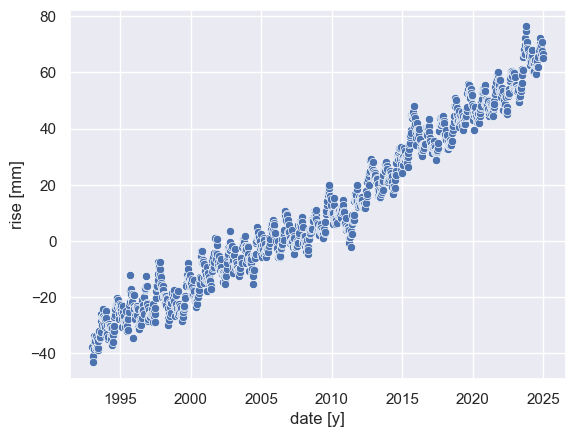

In [3]:
sns.scatterplot(data = data, x = 'date [y]', y = 'rise [mm]')
plt.show()

# How to do a least squares fit

We want to fit:

$$
\underline{l} = 
\begin{pmatrix}
l^{(0)}\\
\vdots\\
l^{(N)}
\end{pmatrix}
= \underbrace{a_0 + a_1 \cdot \underline{t}}_{f(a_0, a_1, \underline{t})}
$$

We can now define the residuals $\underline{v}$ such that:
$$
\underline{v} = f(a_0, a_1, \underline{t}) - \underline{l}
$$

To solve the problem we want to find:
$$
a_0, a_1 = \operatorname{arg min} \underline{v}^T \underline{v}
$$

Since this problem can be linearized we can write the dependence of $f$ on $a_0, a_1$ regarding a fixed $\underline{t}$ as:
$$
\underline{l} = \underline{A}\underline{x}
$$
with
$$
\underline{x} = 
\begin{pmatrix}
a_0\\a_1
\end{pmatrix}
$$
we can now find $\hat{x}$ (e.g. by differentiating and solving for $0$)
$$
\hat{x} = (\underline{A}^T\underline{A})^{-1}\underline{A}^T\underline{l}
$$
## How to find a design matrix $\underline{A}$?
$A$ should describe the funkctional model $f$
$$
f(a_0, a_1, \underline{t}) = \underline{A}\underline{x}
$$
in this example the entries of $A$ are simply:
$$
\underline{A} =
\begin{pmatrix}
1&t^{(1)}\\
\vdots&\vdots\\
1&t^{(N)}\\
\end{pmatrix}
$$
It is the convention to call $\underline{A}$ **Designmatrix**. For general functions $f$ that are linear in the parameters $a_0, \dots a_u$ we find:
$$
\underline{A}
=
\begin{pmatrix}
\partial_{a_0} f(t^{(1)})&\dots&\partial_{a_u} f(t^(1))\\
\vdots&&\vdots\\
\partial_{a_0} f(t^{(1)})&\dots&\partial_{a_u} f(t^(1))\\
\end{pmatrix}
$$
# Rezept zur modelierung funktionaler abhängigkeiten
1. Beobachtungen $\underline{l}$
2. Designmatrix $\underline{A}$
3. Ausgleich $\hat{x} = (A^TA)^{-1}A^T \underline{l}$. 

    *man nennt die matrix $A^TA$ die Normalgleichungsmatrix $N$*, 

    *man bezeichnet $A^T \underline{l}$ mit $\underline{b}$*

4. Definiere die residuen $\hat{\underline{v}} = \underline{A}\underline{\hat{x}}-\underline{l}$
5. Bestimme die Varianz der Gewichtseinheit:
    $$
    m_0^2 = \frac{v^Tv}{n-u}
    $$
6. Bestimme die Geschätzte Kovarianzmatrix der geschätzten Parameter:
    $$
    K = m_0^2 (A^TA)^{-1}
    $$



In [4]:
A = nmp_util.poly_design_matrix(0, data['date [y]'])
offset, m_0_sr, _ = nmp_util.compute_parameters(data['rise [mm]'], A)

print(f'offset : {offset}')
print(f'mean : {data["date [y]"].mean()}')


print(f'm_0 : {np.sqrt(m_0_sr)}')
print(f'standard deviation : {data["rise [mm]"].std()}')

offset : [11.13990662]
mean : 2009.0042768022072
m_0 : 29.023724612643935
standard deviation : 29.023724612643935


offset : 3.0737850314811026
slope : -6164.107367594654
covariance matrix :


Matrix([
[0.000342506225734133, -0.688096472331256],
[  -0.688096472331256,   1382.41801939493]])

<Axes: xlabel='date [y]', ylabel='rise [mm]'>

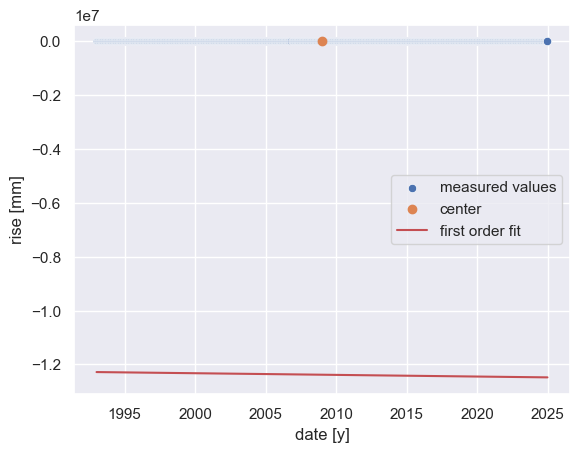

In [5]:
A = nmp_util.poly_design_matrix(1, data['date [y]'])
(offset, slope), m_0_sr, normal_matrix = nmp_util.compute_parameters(data['rise [mm]'], A)

print(f'offset : {offset}')
print(f'slope : {slope}')
print(f'covariance matrix :')
display(sympy.Matrix(m_0_sr * normal_matrix))

x_center = data['date [y]'].mean()
y_center = data['rise [mm]'].mean()

data['linear fit [mm]'] = offset + slope * data['date [y]']

sns.scatterplot(data, x = 'date [y]', y = 'rise [mm]', label = 'measured values')
plt.scatter(x_center, y_center, label = 'center')
sns.lineplot(data, x = 'date [y]', y = 'linear fit [mm]', c = 'r', label = 'first order fit')

offset : 3.073785031426751
slope : -38.01837140577024
covariance matrix :


Matrix([
[0.000342506225734133, -0.688096472331255],
[  -0.688096472331255,   1382.41801939493]])

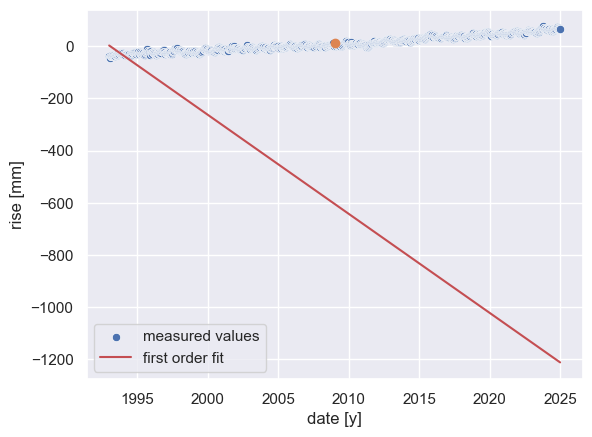

In [6]:
data['relative date [y]'] = data['date [y]'] - data['date [y]'].min()

A = nmp_util.poly_design_matrix(1, data['relative date [y]'])
(offset, slope), m_0_sr, _ = nmp_util.compute_parameters(data['rise [mm]'], A)

print(f'offset : {offset}')
print(f'slope : {slope}')
print(f'covariance matrix :')
display(sympy.Matrix(m_0_sr * normal_matrix))

data['linear fit [mm]'] = offset + slope * data['relative date [y]']

sns.scatterplot(data, x = 'date [y]', y = 'rise [mm]', label = 'measured values')
sns.lineplot(data, x = 'date [y]', y = 'linear fit [mm]', c = 'r', label = 'first order fit')
plt.scatter(x_center, y_center, label = 'center')

parameters : Matrix([[3.37589437705149e-6], [-0.000430261919011521], [0.0185517194472453], [-0.294156614108260], [4.14056316631650], [-35.3072142800920]])
covariance matrix :


Matrix([
[0.000249185445369268, -0.500614625463721],
[  -0.500614625463721,   1005.75821391587]])

<Axes: xlabel='date [y]', ylabel='rise [mm]'>

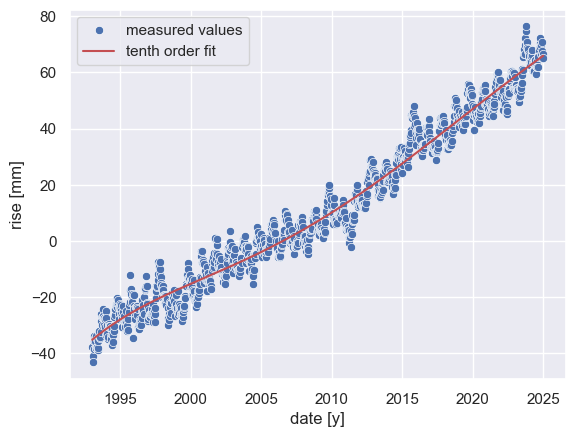

In [7]:
data['relative date [y]'] = data['date [y]'] - data['date [y]'].min()

A = nmp_util.poly_design_matrix(5, data['relative date [y]'])
parameters, m_0_sr, _ = nmp_util.compute_parameters(data['rise [mm]'], A)

print(f'parameters : {sympy.Matrix(parameters)}')
print(f'covariance matrix :')
display(sympy.Matrix(m_0_sr * normal_matrix))

data['poly fit [mm]'] = np.polyval(parameters, data['relative date [y]'])

sns.scatterplot(data, x = 'date [y]', y = 'rise [mm]', label = 'measured values')
sns.lineplot(data, x = 'date [y]', y = 'poly fit [mm]', c = 'r', label = 'tenth order fit')

In [10]:
direct_polyfit = nmp_util.poly_fit(3, np.arange(5)+4, np.arange(5))
via_design_matrix = nmp_util.compute_parameters(np.arange(5)+4, nmp_util.poly_design_matrix(3, np.arange(5)))

#check if all parameters are equal to see if the two methods are equivalent
for a, b in zip(direct_polyfit, via_design_matrix):
    assert np.allclose(a, b)

print('The two methods are equivalent!')

The two methods are equivalent!
